In [1]:
class node:
    t = 0
    ro = 0
    tx=0
    ty=0
    tz=0
    rx=0
    ry=0
    rz=0
    def __init__(self, shape = 'set', operation = 'None',\
    l = 0, b = 0, h = 0,\
    fn = 12, fa = 12, fs = 2, r = 0, r1 = 0,\
    center = "true"):
        self.left = 'None'
        self.right = 'None'
        self.string = ''
        self.operation = operation
        self.shape = shape
        self.l = l
        self.b = b
        self.h = h
        self.fn = fn
        self.fa = fa
        self.fs = fs
        self.r = r
        self.r1 = r1
        self.center = center

    def translate(self, x = 0, y = 0, z = 0):
        self.tx = x
        self.ty = y
        self.tz = z
        self.t = 1
    def rotate(self, x = 0, y = 0, z = 0):
        self.rx = x
        self.ry = y
        self.rz = z
        self.ro = 1

    def name(self):
        if(self.t == 1):
            self.string = 'translate([' + str(self.tx) + ',' + str(self.ty) + ',' + str(self.tz) + ']){\n\t'
        if(self.ro == 1):
            if(self.t == 1):
                self.string = self.string + 'rotate(['+ str(self.rx) + ',' + str(self.ry) + ',' + str(self.rz) + ']){\n\t\t'
            else:
                self.string = self.string + 'rotate(['+ str(self.rx) + ',' + str(self.ry) + ',' + str(self.rz) + ']){\n\t'
        if(self.shape == "cube"):
            self.string = self.string + 'cube(['+ str(self.l) + ',' + str(self.b) + ',' + str(self.h) + '], center = ' + self.center + ');\n'
        if(self.shape == "cylinder"):
            self.string = self.string + 'cylinder($fn = ' + str(self.fn) + ', h = ' + str(self.h) + ', r1 = ' + str(self.r) + \
            ', r2 = ' + str(self.r1) + ', center = ' + self.center + ');\n'
        if(self.shape == "sphere"):
            self.string = self.string + 'sphere($fn = ' + str(self.fn) + ', $fa = ' + str(self.fa) + ', $fs = '+ str(self.fs) + \
            'r = ' + str(self.r) + ');\n'
        if(self.ro == 1 and self.t == 1):
            self.string = self.string + "\t}\n"
        if(self.ro == 1 or self.t == 1):
            self.string = self.string + "}\n"

    def setr(self,r):
        self.r = r
    def setl(self,l):
        self.l = l
    def setb(self,b):
        self.b = b
    def seth(self,h):
        self.h = h
    def setr1(self,r):
        self.r1 = r
    def setoperation(self,operation):
        self.operation = operation


In [2]:
from Shape import node
import sys

def writetofile(filename,string):
    file = open(filename,"a")
    file.write(string)
    file.close()

def createtree(nodes, filename):
    if(len(nodes)==0):
        print("No shapes detected")
        return
    subtree = []
    string = ''
    #Initialize empty node
    present = node()
    #Add the first node in left child
    present.left = nodes[0]
    #Generates function/string for the shape as in openscad 
    nodes[0].name()
    #Add the generated string to the present node
    present.string = nodes[0].string
    #If there is only one node, write it to the file
    if(len(nodes)==1):
        writetofile(filename,present.string)
    #If the number of nodes is more than one enter the loop
    for i,object in enumerate(nodes[1:]):
        #Generate function/statement for the shape as in openscad
        object.name()
        #If Node is child of shapes
        if(object.operation != 'None'):
            #If the right child in tree is free
            if(present.right == 'None'):
                #Assign the right parent 
                present.right = object
                #Update the present string 
                present.string = object.operation + "() {\n\t" + present.string + '\n\t' + object.string + '}\n'
                #Store it for appending into the file
                string = present.string
            else:
                #If right is not free, create a new node and make the present node as left child to the new node
                temp = present
                present =node()
                present.left = temp
                present.string = temp.string
                #Then make the object as right child of the new node
                present.right = object
                #Update the string
                present.string = object.operation + "() {\n\t" + present.left.string + '\n\t' + object.string + '}\n'
                #Store it for appending
                string = present.string
        else:
            #Satisfies this condition only when there is two consecutive parent shape with no child
            if(present.right=='None'):
                #Append the present string to the file
                writetofile(filename,present.string)

            #So as parent-child list is completly traversed, it is added to subtree and the subtree string is appended to the file
            subtree.append(present)
            writetofile(filename,string)
            #Create a new subtree
            string = ''
            present = node()
            present.left = object
            present.string = object.string
            #If the last node is the parent shape node
            if(i==len(nodes)-2):
                writetofile(filename,present.string)
    #If the last node is a child shape node
    if(string!=''):
        writetofile(filename,string)
    #Add the last subtree
    subtree.append(present)
    print("Subtree:",len(subtree))

In [3]:
import cv2
from Shape import node
import copy

#To rearrange the parts in the views, like for front store all the parts such that the center of the shape is arranged in descending order of x pixel value
#otherwise do ascending order in side and top
def re_arrange(objects,type):
    if(type == "front"):
        objects.sort(key = lambda x: x[0][1][0],reverse = True)
    else:
        objects.sort(key = lambda x: x[0][1][0])

def draw_contour(img, out):
     #Converting into greyscale
    imgrey = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    #COnverting into greyscale image to black and white image
    ret, thresh = cv2.threshold(imgrey,127,255,cv2.THRESH_BINARY_INV)
    #Finding contours
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    #REarranging in descending order of area
    hierarchy,contours = zip(*sorted(zip(hierarchy[0],contours),key = lambda x: cv2.contourArea(x[1]),reverse=True))

    for i,c in enumerate(contours):


         if ( hierarchy[i][3] != -1 or (hierarchy[i][3] == -1 and hierarchy[i][2] == -1) ):
            M = cv2.moments(c)
            if(M["m00"] !=0):
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                area = cv2.contourArea(c)
                rect = cv2.minAreaRect(c)

                #Ignoring small areas
                # if(area <= 4):
                #     break
                
                # calculate coordinates of the minimum area rectangle
                box = cv2.boxPoints(rect)
                # draw the countour number on the image
                # cv2.putText(img, "#{}".format( i), (box[0][0], box[0][1]), cv2.FONT_HERSHEY_SIMPLEX,
                #     1.0, (255, 0, 0), 1)
                # draw contours
                cv2.drawContours(img, [c], 0, (0,0, 255), 1)
    cv2.imwrite(out,img)

def add_part(objects,part,pos,type,ratio):

    #Translate based on the centers of the given shape with largest shape
    if(type == "front"):
        part[0].translate((part[1][0]-pos[0]) * ratio , 0 , (pos[1]-part[1][1]) * ratio )
    if(type == "side"):
        part[0].translate(0 , (part[1][0]-pos[0]) * ratio  , (pos[1]-part[1][1]) * ratio )
    if(type == "top"):
        part[0].translate(-(pos[1]-part[1][1]) * ratio , (part[1][0]-pos[0]) * ratio , 0 )

    #Search for the parent shape and place it inside that parent list
    for i,object in enumerate(objects):
        if(cv2.pointPolygonTest(object[0][2],part[1],False)>=0):
            part[0].operation = "difference"            
            #Adding in position
            object.append(part)
            return

    #If shape not found his parent, make a new list making it has parent 
    objects.append([part])
    return

def combining(front_parts,side_parts,top_parts,roundOffApprox):
#All the views are thought to be seen in y direction
#For cube the "l" is length that is length of the rectangle/sqaure, "h" is height that is nothing but breadth of rectangle/sqaure,
# "b" is the breath(thickness in y direction) of the cube
# Cylinder will be upright position along z-axis(i.e when no ration is applied)

#Looping through the Different parent child lists
    for i,front in enumerate(front_parts):
        first = 0
        #looping through all the parts of a parent and its child
        for j,part_f in enumerate(front):
            #part length is usually 5 - includes shape object,center,contour,height and width, if its six the shape is already considered and finalised
            if(len(part_f) >= 6):
                continue
            #Give the width of the parent to all its child when the parent is width found from side view
            if(first == 1):
                #If the child shape is cube
                if(part_f[0].shape == "cube"):
                    #Parent is also cube
                    
                    if(front[0][0].shape == "cube"):
                        part_f[0].b = front[0][0].b
                    else:
                        part_f[0].b = front[0][0].h
                    #when the parent is rotated in z axis
                    if(front[0][0].rz!=0):
                        part_f[0].b = front[0][3]
                #If the child is cylinder
                if(part_f[0].shape == "cylinder"):
                    #Parent is cube
                    if(front[0][0].shape == "cube"):
                        part_f[0].h = front[0][0].b
                    else:
                        part_f[0].h = front[0][0].h
                    #when the parent is rotated in z axis
                    if(front[0][0].rz!=0):
                        part_f[0].h = front[0][3]
            #For checking whether the front shape is visible in side
            found = 0
            #Search side view
            for k,side in enumerate(side_parts):
                #For adding rest of the shapes in side view list, once a shape is found
                add_rest = 0
                for l,part_s in enumerate(side):
                    # ADD inner parts of side view only visible from side view and making sure the same shape is not added again once the shape is available in side view
                    if(add_rest == 1 and part_s[3]!=-1): 
                        found = 1
                        #Increasing the size of parts list
                        part_s.append("used")
                        part_s[3]=-1
                        #Giving the x translation
                        part_s[0].tx = part_f[0].tx
                        #If the shape is cylinder give height to it
                        if(part_s[0].shape == "cylinder"):
                            part_s[0].h = part_f[4]
                        #If its a cube give breadth
                        elif(part_s[0].shape == "cube"):
                            part_s[0].b = part_f[4]
                        front.append(part_s)

                        continue
                    #check whether the height iin front view is same in top view
                    if(abs(part_f[3]-part_s[3]) < roundOffApprox):
                        #If the shape is found in side view     
                        found = 1
                        #If its a parent in front view
                        if(j == 0):
                            first = 1
                        #If the side shape is not parent then its protruding, so make the operation as union
                        if(l!=0):
                            part_s[0].operation="union"
                        #If Front view is cube
                        if(part_f[0].shape =="cube"):
                            #If side view is also cube
                            if(part_s[0].shape == "cube"):
                                #Check whether it is cylinder in top view or if there is any rotation in z-axis if the top view is also found to be cube

                                for top in top_parts:
                                    for m,part_t in enumerate(top):
                                        #Checking whether the shape is available in top view by comparing the height in top view 
                                        # with the width in front view, as all the shapes are considered to be viewed in the direction of y-axis we need to compare 
                                        # the height in top view with width in front view
                                        if(abs(part_t[3] - part_f[4]) < roundOffApprox and len(part_t)==5):
                                           
                                            #If the shape in top view is child it must be protuding from it's parent to be visible in front view, so 
                                            # we change the operation of the shape of the top view to union operation 
                                            if(m!=0):
                                                part_t[0].operation = "union"
                                            #If its a circle from top view replace the front view in "front_part" list with top view shape, while giving it a height
                                            #  and z-translate
                                            if(part_t[0].shape == "cylinder"):
                                                #Providing height and z-tranzlate for the shape in top view
                                                part_t[0].h = part_f[0].h
                                                part_t[0].tz = part_f[0].tz
                                                #Get to know the position of which parent we are adding in "front_part" so that the remaining shapes
                                                # in the top view after this shape can be added later into the "front_part" list 
                                                part_t[1] = j
                                                #Marking that the shape in the top view is used
                                                part_t[2] = -1
                                                part_t.append("used")
                                                #Replace the shape in the front view by the shape obtained from top view
                                                part_f[0] = part_t[0]
                                                #Mark that the side view is used
                                                part_s[3] = -1
                                                #Giving signal to add rest of the child in side view after the current shape
                                                add_rest = 1
                                                break
                                            if(part_t[0].shape == "cube" and part_s[0].ry == 0 and part_f[0].ry == 0 and part_t[0].rz != 0 and part_t[0].rz != 90):
                                                #For the top view, cube will be rotated along x-axis so we need to provide them breadth rather
                                                #  than height 
                                                part_t[0].b = part_f[0].h
                                                #Provide the z-translation from top view
                                                part_t[0].tz = part_f[0].tz
                                                #Get to know the position of which parent we are adding in "front_part" so that the remaining shapes
                                                # in the top view after this shape can be added later into the "front_part" list 
                                                part_t[1] = j
                                                #Marking that the shape in the top view is used
                                                part_t[2] = -1
                                                part_t.append("used")
                                                #Replace the shape in the front view by the shape obtained from top view
                                                part_f[0] = part_t[0]
                                                #ginving the thickness of the shape, helpful when the parent is rotated along z axis
                                                part_f[3] =part_t[3]
                                                #Mark that the side view is used
                                                part_s[3] = -1
                                                #Giving signal to add rest of the child in side view after the current shape
                                                add_rest = 1
                                                break
                                    else:
                                        #Using for else construct, which helps here to continue to traverse through the list until the shape is found in top view 
                                        # or it exists from the top_part loop 
                                        continue
                                    break
                            #If the shape was found in top view and we if we replaced with top view, then skip rest of the work below it
                            if(part_s[3] == -1):
                                continue

                            #If the side view is cylinder
                            if(part_s[0].shape == "cylinder"):
                                #Get height of the cylinder
                                part_s[0].h = part_f[0].l
                                #Get x-translation
                                part_s[0].tx = part_t[0].tx
                                #If the cube is front view cube is rotated along y axis
                                part_s[0].ry = part_t[0].ry
                                #Replace front view by side
                                part_f[0] = part_s[0]
                            
                            #If the side view is cube
                            if(part_s[0].shape == "cube"):
                                #If the cube is rotated in front view i.e along y axis, then just provide the thickness and y translation
                                if(part_f[0].ry != 0 or part_s[0].ry == 0):
                                    part_f[0].b = part_s[0].l
                                    part_f[0].ty = part_s[0].ty
                                    part_s[3] = -1
                                    add_rest = 1
                                    continue
                                else:
                                    #Replacing front view by side view 
                                    #thickness of the view
                                    part_s[0].b = part_f[0].l
                                    # x translation
                                    part_s[0].tx = part_f[0].tx
                                    #Replace front view by side view
                                    part_f[0] = part_s[0]
                                    part_s[3] = -1
                                    add_rest = 1
                                    continue

                        #If the shape in Front View is cylinder 
                        if(part_f[0].shape == "cylinder"):
                            # If the side view is cube, which is obvious but still checking
                            if(part_s[0].shape == "cube"):
                                # The thickness/height for the cylinder is given by the length of the cube in side view(as side view shapes are rotated 
                                # in 90 about z-axis) and also give the y-translation
                                part_f[0].h = part_s[0].l
                                part_f[0].ty = part_s[0].ty
                                #If the cube is rotated along x axis, by x axis rotation in side view is given by zy as we are rotating the side view 
                                # by 90 along z axis
                                part_f[0].rx = part_s[0].ry 

                        #Side shape is used
                        part_s[3] = -1
                        #Add the rest of the shapes in side view for this parent/ this child's parent 
                        add_rest = 1
                        continue
                #If the shape in front view is already found, dont check any other shapes in the next parent child list
                if(add_rest==1):
                    break

            #If the corresponding shape of the front view is not found in side view check in top view to get the thickness of the shape
            if(found == 0):
                #Search top view, here we are assuming 
                for top in top_parts:
                    for m,part_t in enumerate(top):
                        #Checking whether the heigth of top view is same as width in front view and the top view shape should not be used before
                        if((abs(part_t[3]-part_f[4]) < roundOffApprox) and len(part_t)==5):
                            #Checking whether the front view is a parent or not
                            if(j == 0):
                                first = 1
                            #If the shape in top view is child it must be protuding from it's parent to be visible in front view, so 
                            # we change the operation of the shape of the top view to union operation 
                            if(m!=0):
                                part_t[0].operation = "union"
                            #If it's a cylinder provide height and y-translation
                            if(part_f[0].shape == "cylinder"):
                                #This checking is not required as it is obivous, but still doing anyway
                                if(part_t[0].shape == "cube"):
                                    part_f[0].h = part_t[0].h
                                    part_f[0].ty = part_t[0].ty
                                    #If the cube is rotated in z axis
                                    part_f[0].rz = part_t[0].rz
                                    #For adding the rest of the child later give the top shape with height, z-translation and the position of the
                                    # "front_parts" we are comparing now
                                    part_t[0].b = part_f[3]
                                    part_t[0].tz = part_f[0].tz
                                    #Get to know the position of which parent we are adding in "front_part" so that the remaining shapes
                                    # in the top view after this shape can be added later into the "front_part" list 
                                    part_t[1] = j
                                    #Marking that the shape in the top view is used
                                    part_t[2] = -1
                                    part_t.append("used")
                                    break

                            if(part_f[0].shape == "cube"):

                                part_t[0].tz = part_f[0].tz
                                if(part_t[0].shape == "cube"):
                                    part_t[0].b = part_f[0].h
                                    #Check whether the cube is rotated along z axis( in top view)
                                    if(part_t[0].rz != 0):
                                        part_f[0] = part_t[0]
                                    else:
                                        #Getting thickness for the front view, which is the length of the top view
                                        part_f[0].b = part_t[0].l
                                        part_f[0].ty = part_t[0].ty

                                elif(part_t[0].shape == " cylinder"):
                                    #If cube is rotated along y axis
                                    part_t[0].ry = part_f[0].ry
                                    part_t[0].h = part_f[0].h
                                    part_f[0] = part_t[0]
                                
                                part_t[1] = j
                                #Marking that the shape in the top view is used
                                part_t[2] = -1
                                part_t.append("used")
                                break
                    else:
                        #Continue until you find the matching of front and top view
                        continue
                    break

    #Add the shape that is only visible in side view and top view(parent part and its child)
    for side in side_parts: 
        #If the parent is not used, get the thickness from top view, we are not checking front view because all the shapes visible in front view 
        # are already considered         
        if(side[0][3]!=-1):
            for part_s in side:
                #Looping through topo view
                for k,top in enumerate(top_parts):
                    for l,part_t in enumerate(top):
                        #Check whether their width are same in both side and top view and top view should not be used already
                        if((abs(part_s[4]-part_t[4]) < roundOffApprox) and len(part_t)==5) :

                            if(part_s[0].shape=="cube"):
                                #Giving z-translation
                                part_t[0].tz = part_s[0].tz
                                if(part_t[0].shape == "cube"):
                                    #Giving thivkness to top view shape
                                    part_t[0].b = part_s[0].h
                                    #Check whether the cube is rotated along z axis( in top view)
                                    if(part_t[0].rz != 0):
                                        part_s[0] = part_t[0]
                                    else:
                                        #Getting thickness for the front view
                                        part_s[0].b = part_t[0].h
                                        #Give x-translation
                                        part_s[0].tx = part_t[0].tx

                                elif(part_t[0].shape == " cylinder"):
                                    #Rotated along x axis, but as we have rotated the side view along z axis to 90, we use ry of side view
                                    part_t[0].rx = part_s[0].ry
                                    part_t[0].h = part_s[0].h
                                    part_s[0] = part_t[0]
                                
                                #Getting the location of the parent-child side view we are going to add to "front_parts"
                                part_t[1] = len(front_parts)
                                #Marking that the shape in the top view is used
                                part_t[2] = -1
                                part_t.append("used")
                            #If its a cylinder get its height
                            if(part_s[0].shape=="cylinder"):
                                #This checking is not required as it is obivous, but still doing anyway
                                if(part_t[0].shape == "cube"):
                                    #Get height
                                    part_s[0].h = part_t[0].h
                                    #Give x-translation
                                    part_s[0].tx = part_t[0].tx
                                    #Rotation in z axis
                                    part_s[0].rz = part_t[0].rz
                                    #For adding the rest of the child later give the top shape with height, z-translation and the position of the
                                    # "front_parts" we are comparing now
                                    part_t[0].b = part_s[3]
                                    part_t[0].tz = part_s[0].tz
                                    #Get to know the position of which parent we are adding in "front_part" so that the remaining shapes
                                    # in the top view after this shape can be added later into the "front_part" list 
                                    part_t[1] = len(front_parts)
                                    #Marking that the shape in the top view is used
                                    part_t[2] = -1
                                    part_t.append("used")
            #Append whole parent-child list into "front_parts"
            front_parts.append(side)

    #Add shapes only visible in top
    for top in top_parts:
        #Need to give the top view heights
        height = -1
        #For z-translation
        tz = -1
        #Position of the parent-child list where we need to add, which is stores in part list earlier
        position = -1
        #Loop through parent-child list to first find the position of the shape which is used while comparing with front view
        for part_t in top:
            #Check whether the height of the used shape is given and also check whether the shape in top view is already used
            if(height != -1 and len(part_t)==5):
                #If its a cylinder provide height and z-translation
                if(part_t[0].shape == "cylinder"):
                    part_t[0].h = height
                    part_t[0].tz = tz
                # If its a cube provide breadth(as the cube is rotated along x axis in top view) and z-translation
                elif (part_t[0].shape == "cube"):
                    part_t[0].b = height
                    part_t[0].tz = tz
                #Appending the shape in front_parts in the position obtained from previous top shape
                try:
                    front_parts[position].append(part_t)
                except:
                    print("Error occurred")
            #Check if the given top view is used
            try:
                class Spam(int): pass
                if(isinstance(Spam(part_t[2]),int)):
                    #Store its z-translation
                    tz = part_t[0].tz
                    #Get the position in front_parts list to add the rest of the child shape
                    position = part_t[1]
                    #Getting the height of the top shape already used, for cube its given by breadth, for cylinder, it is it's height 
                    if(part_t[0].shape == "cylinder"):
                        height = part_t[0].h
                    elif (part_t[0].shape == "cube"):
                        height = part_t[0].b
            except TypeError:
                print("")

    return front_parts


def detect(c):
    # initialize the shape name and approximate the contour
    shape = "unidentified"
    peri = cv2.arcLength(c, True)
    #Finding the number of line segment required to make the polygon
    approx = cv2.approxPolyDP(c, 0.015 * peri, True)
    #Cylinder type in openscad for making regular prism
    cylinder_type = 0

    # if the shape is a triangle, it will have 3 vertices
    if len(approx) == 3:
        shape = "triangle"
        cylinder_type = 3
    # if the shape has 4 vertices, it is either a square or a rectangle
    elif len(approx) == 4:
        # compute the bounding box of the contour and use the
        # bounding box to compute the aspect ratio
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)
        rect = cv2.minAreaRect(c)
        ar = rect[1][0] / float(rect[1][1])
        # a square will have an aspect ratio that is approximately
        # equal to one, otherwise, the shape is a rectangle
        shape = "cube" if ar >= 0.999 and ar <= 1.001 else "rectangle"

    # if the shape is a pentagon, it will have 5 vertices
    elif len(approx) == 5:
        shape = "pentagon"
        cylinder_type = 5
    # if the shape is a hexagon, it will have 6 vertices
    elif len(approx) == 6:
        shape = "hexagon"
        cylinder_type = 6
    # otherwise, we assume the shape is a circle
    else:
        shape = "circle"
        cylinder_type = 1

    # return the name of the shape
    return shape,cylinder_type

def valid_contours(img,type,ratio):
    #List to build parent and child shapes
    objects = []
    #Converting into greyscale
    imgrey = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    #COnverting into greyscale image to black and white image
    ret, thresh = cv2.threshold(imgrey,127,255,cv2.THRESH_BINARY_INV)
    #Finding contours
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    #Rearranging such that the contours are arranged in descending order
    hierarchy,contours = zip(*sorted(zip(hierarchy[0],contours),key = lambda x: cv2.contourArea(x[1]),reverse=True))

    #Looping through all contours
    for i,c in enumerate(contours):
         #Choosing inner side of the two same shape created by thickness of the line  
        if ( hierarchy[i][3] != -1 or (hierarchy[i][3] == -1 and hierarchy[i][2] == -1) ):
            M = cv2.moments(c)
            if(M["m00"] !=0):
                #Getting the center of the contour
                cX = int(M["m10"] / M["m00"]) 
                cY = int(M["m01"] / M["m00"])
                #Getting Contour area
                area = cv2.contourArea(c)
                #Rescaling based on input from user
                area = area * ratio
                #getting minimun area rectangle that is enclosing the contour
                rect = cv2.minAreaRect(c)
                #Ignoring small areas
                if(area <= 4*ratio):
                    break
                # calculate coordinates of the minimum area rectangle
                box = cv2.boxPoints(rect)
                #Rescaling based on input from user
                rectLength = rect[1][0] * ratio
                rectBreadth = rect[1][1] * ratio

                #it's a horizontal rectangle which encloses the contour
                x,y,w,h = cv2.boundingRect(c)
                w = w * ratio
                h = h * ratio
                #Making largest contour's center has reference for translation of other shape
                if(len(objects)==0):
                    pos = [cX,cY]
                
                # draw the contour number on the image
                # cv2.putText(img, "#{}".format(i), (box[0][0], box[0][1]), cv2.FONT_HERSHEY_SIMPLEX,
                #     1.0, (255, 0, 0), 1)
                # draw contours
                cv2.drawContours(img, [c], 0, (0,0, 255), 1)
                #Detecting the shape of the contour
                shape, cylinder_type = detect(c)
                    
                # To store the shape and its details
                part = []

                if(shape == "cube"):
                    #Adding shape
                    part.append(node(shape="cube",l=rectLength,b=rectLength,h=rectLength))
                    #Giving rotatation
                    if(type == "front"):
                        part[0].rotate(0,rect[2],0)
                    elif(type == "side"):
                        part[0].rotate(0,rect[2],90)
                    elif(rect[2]==0):
                        part[0].rotate(90,0,90)
                    else:
                        part[0].rotate(90,0,rect[2])
                        
                    #Adding center of the contour
                    part.append(tuple([cX,cY]))
                    #Adding contour
                    part.append(c)
                    #Adding height of the horizontal rectangle enclosing the contour
                    part.append(h)
                    #Adding width of the horizontal rectangle enclosing the contour
                    part.append(w)
                    #Adding to the list of shape in parent child manner
                    add_part(objects,part,pos,type,ratio)
                elif(shape == "rectangle"):
                    part.append(node(shape="cube",l=rectLength,b=rectLength,h=rectBreadth))
                    if(type == "front"):
                        part[0].rotate(0,rect[2],0)
                    elif(type == "side"):
                        part[0].rotate(0,rect[2],90)
                    #If there is no rotation in top view rotate 90 along in both x and z axis 
                    elif(rect[2]==0):
                        part[0].rotate(90,0,90)
                    else:
                        #If there is some rotation, rotate in z axis
                        part[0].rotate(90,0,rect[2])

                    part.append(tuple([cX,cY]))
                    part.append(c)
                    part.append(h)
                    part.append(w)
                    add_part(objects,part,pos,type,ratio)
                #Cylinder type in openscad
                elif(cylinder_type > 0):
                    #Cylinder
                    if(shape == "circle"):
                        part.append(node(shape="cylinder",r = rectLength/2,r1 = rectLength/2,h=rectLength))
                        if(type == "front"):
                            part[0].rotate(90,0,0)
                        elif(type == "side"):
                            part[0].rotate(0,90,0)
                        part.append(tuple([cX,cY]))
                        part.append(c)
                        part.append(h)
                        part.append(w)
                        add_part(objects,part,pos,type,ratio)
                    else:
                        #Regular prism
                        (x,y),radius = cv2.minEnclosingCircle(c)
                        radius = radius * ratio
                        part.append(node(shape="cylinder",r = radius,r1 = radius,h=rectLength,fn = cylinder_type))
                        if(type == "front"):
                            part[0].rotate(90,-90 - rect[2],0)
                        elif(type == "side"):
                            part[0].rotate(0,90,0)
                        part.append(tuple([cX,cY]))
                        part.append(c)
                        part.append(h)
                        part.append(w)
                        add_part(objects,part,pos,type,ratio)          
                else:
                    print("shape not detected")
    # cv2.imwrite("result1"+type+".png",img)
    return objects

In [4]:
import argparse
import copy
import json
import os
import shutil

import cv2
import numpy as np
from flask import Flask, Response, request

from Shape import node
from tree import createtree
from operation import add_part,re_arrange,valid_contours,combining,detect,draw_contour

from matplotlib import pyplot as plt
from IPython.display import Image


def Dimensioning(userId,view,image):

    #Creating temp directory if not present
    os.makedirs('static/temp', exist_ok=True)
    #Getting user input from app
    img = cv2.imread(image,cv2.IMREAD_UNCHANGED)
    #Initialization
    ratio = 0
    shape = "unidentified"
    #Getting the size of image
    w,h,_=img.shape
    drawSize = int(h/300)
    #Convert image to grayscale
    imgrey = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    #Convert image to black and white
    ret, thresh = cv2.threshold(imgrey,127,255,cv2.THRESH_BINARY_INV)
    #Find contours
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    #Arrange the contours in descending order of area
    hierarchy,contours = zip(*sorted(zip(hierarchy[0],contours),key = lambda x: cv2.contourArea(x[1]),reverse=True))

    for i,c in enumerate(contours):
        #Get the outer most closed contour
        if(hierarchy[i][3] != -1  or (hierarchy[i][3] == -1 and hierarchy[i][2] == -1) ):
            M = cv2.moments(c)
            if(M["m00"] !=0):
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                #Getting the minimum area rectangle enclosing the contour
                rect = cv2.minAreaRect(c)
                box = cv2.boxPoints(rect)
                #Getting horizontal rectangle enclosing the contour
                x,y,w,h = cv2.boundingRect(c)

                # cv2.putText(img, "#{}".format(i), (box[0][0], box[0][1]), cv2.FONT_HERSHEY_SIMPLEX,
                #     textSize, (255, 0, 0), drawSize,cv2.LINE_AA)

                # draw contours
                cv2.drawContours(img, [c], 0, (0,0, 255), drawSize)
                #detect Shape
                shape, cylinder_type = detect(c)
                #Length per pixel
                ratio = 1.0/rect[1][0]
                if(shape == "unidentified"):
                    continue
                #w is the width of the rectagle enclosing the circle, i.e diameter of the circle
                if(shape=="Circle"):
                    ratio = 1/w
                break
    
    #highlighted image path
    folder = 'static/temp/' + userId
    os.makedirs(folder, exist_ok=True)
    #Check whether file already exist and delete
    try:
        os.remove(folder + '/' + view + '.png')
    except: pass

    path_file = (folder + '/' + view + '.png')

    #reducing the image size
    small = cv2.resize(img, (0,0), fx=0.5, fy=0.5) 
    cv2.imwrite(path_file,small)
    #Convert float to string
    ratio = str(ratio)
    #Json data to send
    data={'image': path_file,'shape': shape,'ratio': ratio}
#     plt.imshow(image)
#     plt.show()
    display(Image(filename = path_file))
    return json.dumps(data)

In [5]:
def Convert(userId, front_image, side_image, top_image, fratio, sratio, tratio):
    os.makedirs('static', exist_ok=True)

    img_front = cv2.imread(front_image,cv2.IMREAD_UNCHANGED)
    img_side = cv2.imread(side_image,cv2.IMREAD_UNCHANGED)
    img_top = cv2.imread(top_image,cv2.IMREAD_UNCHANGED)

    fratio = float(fratio)
    sratio = float(sratio)
    tratio = float(tratio)
    filePath = "static/temp/"+userId
#Remove temp file created while dimensioning
    try:
        shutil.rmtree(filePath)
    except OSError as e:
        print ("Error: %s - %s." % (e.filename, e.strerror))

    primitive = []
    #front
    object_front = valid_contours(img_front,"front",fratio)
    re_arrange(object_front,"front")
    front_parts = []
    for object in object_front:
        for i in object:
            front_parts.append(i[0])
    
    #side
    object_side = valid_contours(img_side,"side",sratio)
    re_arrange(object_side,"side")
    side_parts = []
    for object in object_side:
        for i in object:
            side_parts.append(i[0])

    #Top
    object_top = valid_contours(img_top,"top",tratio)
    re_arrange(object_top,"top")
    top_parts = []
    for object in object_top:
        for i in object:
            top_parts.append(i[0])

    #Thershold error        
    minApprox = 4.0 * max(fratio,sratio,tratio)
    primitive = combining(object_front,object_side,object_top,minApprox)
    final = []
    for set in primitive:
        for shape in set:
            final.append(shape[0])
    
    #Check whether file already exist and delete
    try:
        os.remove('static/' + userId + '.scad')
    except: pass

    #Generate scad file
    path_file = ('static/' + userId + '.scad')
    #If the list is empty no shape has been detected
    if(len(final) == 0):
        path_file = 'static/error.txt'
        f = open(path_file, "w")
        f.write("Cannot determine the 3d geometry, check your files again!")
        f.close()
    createtree(final,path_file)

    return json.dumps(path_file)


In [20]:
userId="1"
front_image = "front2.png"
side_image = "side2.png"
top_image = "top2.png"

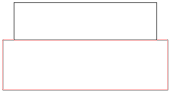

'{"image": "static/temp/1/front.png", "shape": "rectangle", "ratio": "0.0030303035907728883"}'

In [30]:
Dimensioning(userId,"front",front_image)

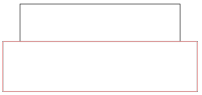

'{"image": "static/temp/1/side.png", "shape": "rectangle", "ratio": "0.0025706944907525446"}'

In [31]:
Dimensioning(userId,"side",side_image)

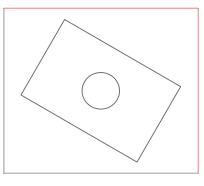

'{"image": "static/temp/1/top.png", "shape": "rectangle", "ratio": "0.002570694087403599"}'

In [32]:
Dimensioning(userId,"top",top_image)

In [33]:
#Multiply the outputed ratio by the width of the rectangle or the diameter in case of circle
"""This is done because lets say the images are taken from camera the the pixel to dimension ratio
might changes for each view, so we take the pixel to dimension ratio for converions"""
fratio = 0.0030303035907728883 * 34 #Width of rectangle in highlighted in front view 
sratio = 0.0025706944907525446 * 40 #Width of rectangle in highlighted in front view
tratio = 0.002570694087403599 * 40 #Width of rectangle in highlighted in front view

In [34]:
Convert(userId,front_image, side_image, top_image,fratio, sratio, tratio)



Subtree: 2


'"static/1.scad"'

In [27]:
import viewscad
from solid import *

r = viewscad.Renderer(width=300,height=200)
c = cylinder(h = 30.0, r1 = 4.251784522192662, r2 = 4.251784522192662, center = true);
r.render(c)
# renderer = viewscad.Renderer(openscad_exec='static/'+userId+'.scad')

Exception: openscad exec not found!